In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d puneet6060/intel-image-classification



Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 96% 332M/346M [00:02<00:00, 170MB/s]
100% 346M/346M [00:02<00:00, 150MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/intel-image-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Set Up Directories.


In [8]:
train_dir = '/content/seg_train/seg_train'
test_dir = '/content/seg_test/seg_test'
val_dir = '/content/seg_pred/seg_pred'

### 3. Data Augmentation and Generators:

In [11]:

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, rotation_range=20,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150),
                                                    batch_size=32, class_mode='categorical',
                                                    subset='training')
val_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150),
                                                  batch_size=32, class_mode='categorical',
                                                  subset='validation')

# Create test generator
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150),
                                                  batch_size=32, class_mode='categorical',
                                                  shuffle=False)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Model Archiitecture

In [12]:
# Model definition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,036,742 (72.62 MB)

 Trainable params: 19,036,742 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Training
history = model.fit(train_generator, epochs=50, validation_data=val_generator,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


351/351 ━━━━━━━━━━━━━━━━━━━━ 97s 253ms/step - accuracy: 0.4599 - loss: 1.3665 - val_accuracy: 0.5959 - val_loss: 1.0302 - learning_rate: 0.0010
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 226ms/step - accuracy: 0.6460 - loss: 0.9363 - val_accuracy: 0.6979 - val_loss: 0.7913 - learning_rate: 0.0010
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 228ms/step - accuracy: 0.7004 - loss: 0.7920 - val_accuracy: 0.7550 - val_loss: 0.6698 - learning_rate: 0.0010
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 224ms/step - accuracy: 0.7405 - loss: 0.7162 - val_accuracy: 0.7589 - val_loss: 0.6803 - learning_rate: 0.0010
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 86s 241ms/step - accuracy: 0.7526 - loss: 0.6785 - val_accuracy: 0.7814 - val_loss: 0.6193 - learning_rate: 0.0010
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 81s 225ms/step - accuracy: 0.7671 - loss: 0.6357 - val_accuracy: 0.7682 - val_loss: 0.6183 - learning_rate: 0.0010
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 87s 241ms/step - accuracy: 0.7893 - loss:

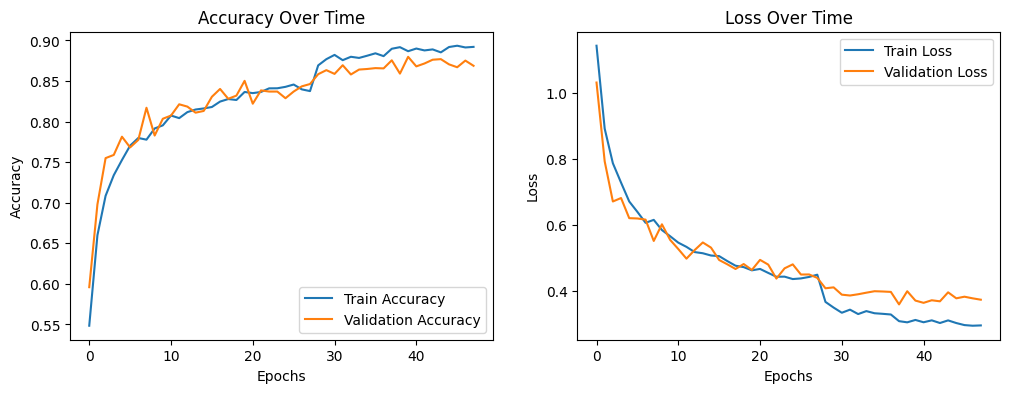

In [15]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Time')

plt.show()

In [14]:
# Evaluation
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9032 - loss: 0.3067
Test accuracy: 0.8783


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
              precision    recall  f1-score   support

   buildings       0.81      0.92      0.86       437
      forest       0.97      0.98      0.97       474
     glacier       0.86      0.83      0.85       553
    mountain       0.88      0.79      0.83       525
         sea       0.86      0.90      0.88       510
      street       0.90      0.87      0.89       501

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



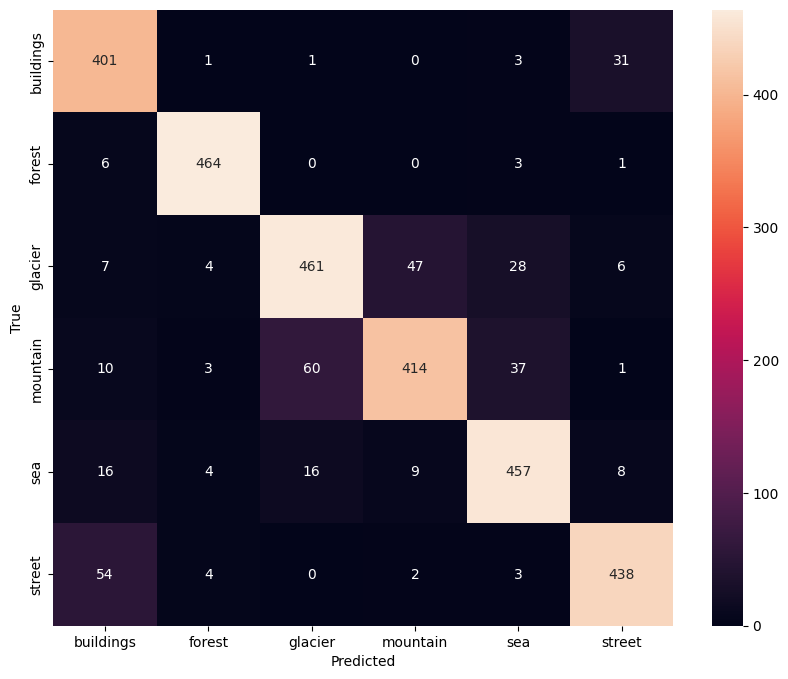

In [16]:
# Classification report and confusion matrix
test_generator.reset()
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = predictions.argmax(axis=1)

class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



----------